# Red Sox Pregame Analysis

This notebook explores T traffic before Sox games.

## Setup

In [1]:
# Libraries.
import datetime as dt
import math
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [2]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [486]:
# Other settings.

# Stations to highlight.
td_stations = ['North Station']

# Default figure size.
default_figsize = (12,8)
default_figsize_slides = (12,6)

# Base units of timedeltas.
timedelta_base = 3.6e12

# Day of week mapping.
days_of_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Baseball season information.
# There are little edge cases regarding the playoffs/WS and such. Just use April through October to make things easiest.
season_start_month = 4
season_end_month   = 10
season_months = np.arange(season_start_month, season_end_month+1)

## Data

### Sox

In [268]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

# Get hour temporarily.
sox['game_hour_rounded'] = pd.DatetimeIndex(sox.game_datetime_rounded).hour

In [269]:
# Deal with doubleheaders. Drop early games.
game_date_sizes = sox.groupby('game_date').size()
doubleheader_dates = list(game_date_sizes[game_date_sizes > 1].index)

# Show doubleheaders.
# sox[sox.game_date.isin(pd.DatetimeIndex(doubleheader_dates).date)]

# Drop them.
sox = sox[(sox.game_date.isin(pd.DatetimeIndex(doubleheader_dates).date) == False) | ((sox.game_date.isin(pd.DatetimeIndex(doubleheader_dates).date)) & (sox.game_hour_rounded < 15))]

# Drop hour.
sox.drop('game_hour_rounded',axis=1,inplace=True)

In [ ]:
sox.head()

### Gatecount

In [7]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to columns that we need.
gatecount = gatecount.ix[:,['locationid','name','line_1','line_2','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
gatecount.service_day = pd.to_datetime(gatecount.service_day)
gatecount.service_datetime = pd.to_datetime(gatecount.service_datetime)

# Get time of day.
gatecount['service_time'] = pd.DatetimeIndex(gatecount.service_datetime).time

# Add day of week.
gatecount = date.add_day_of_week(gatecount.copy())

In [ ]:
gatecount.head()

In [326]:
# Perform merge.
gatecount_sox = gatecount.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
gatecount_sox['game_played'] = (gatecount_sox.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
gatecount_sox['time_until_game_start'] = gatecount_sox.game_datetime_rounded - gatecount_sox.service_datetime

# Separate into classes: weekday/weekend and early/late.
gatecount_sox['day_of_week_class'] = 'Weekday'
gatecount_sox.ix[gatecount_sox.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
gatecount_sox['game_time_class'] = 'Early'
gatecount_sox.ix[gatecount_sox.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

# Add line count and an "entries per line" column for each station.
gatecount_sox['lines'] = 1
gatecount_sox.ix[gatecount_sox.line_2.isnull() == False,'lines'] = 2
gatecount_sox['entries_per_line'] = gatecount_sox.entries / gatecount_sox.lines

# Clean up lines.
gatecount_sox.line_1 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_1]
gatecount_sox.line_2 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_2]

In [ ]:
gatecount_sox[gatecount_sox.game_played].head()

### Farebox

In [20]:
# Path for routes.
routes_file = '../../../data/SignCodesAndRoutes.csv'

# Get routes.
routes = pd.read_csv(routes_file)
# Restrict to Green Line D.
gl_routes = routes[(routes['mode'] == 'G/Line') & routes.publicroute.isin(['Green Line '+l for l in 'BCDE'])]
# Get signcodes.
gl_signcodeids = set(gl_routes.signcodeid)

# Get simplified version for merge.
gl_sc_pr = gl_routes[['signcodeid','publicroute']]

In [ ]:
gl_routes

In [ ]:
# Farebox directories.
farebox_root = '../../../data/farebox_all/'

# Empty container for data.
farebox = None
# Traverse each file and add to the main.
for farebox_file in os.listdir(farebox_root):
    farebox_month = pd.read_csv(farebox_root+farebox_file)
    if farebox is None:
        farebox = farebox_month
    else:
        farebox = farebox.append(farebox_month)

# Restrict to green line D. Discard old farebox data.
gl_farebox = farebox[farebox.signcodeid.isin(gl_signcodeids)]
del farebox

# Calculate entries.
gl_farebox['entries'] = gl_farebox.charlie + gl_farebox.cash

# Drop old columns.
gl_farebox.drop(['charlie','cash'], axis=1, inplace=True)

# Rename some columns for consistency.
gl_farebox.rename(columns={'servicedate':'service_day', 'servicetime':'service_time'}, inplace=True)

# Make service_day a string for now.
gl_farebox.service_day = gl_farebox.service_day.astype(np.str)

# Fix dates and times for post-midnight 
gl_farebox_post_midnight = gl_farebox[gl_farebox.service_time >= 2400]
# Fix times.
gl_farebox_post_midnight.service_time = gl_farebox_post_midnight.service_time-2400
# Fix dates.
gl_farebox_post_midnight.service_day = pd.to_datetime(gl_farebox_post_midnight.service_day) + np.timedelta64(1,'D')
gl_farebox_post_midnight.service_day = pd.DatetimeIndex(gl_farebox_post_midnight.service_day).format()
# Get pre-midnight data.
gl_farebox_pre_midnight = gl_farebox[gl_farebox.service_time < 2400]
# Recombine.
gl_farebox = gl_farebox_pre_midnight.append(gl_farebox_post_midnight)
# Housekeeping.
del gl_farebox_pre_midnight, gl_farebox_post_midnight

# Zero-pad service times.
gl_farebox.service_time = gl_farebox.service_time.map('{:04}'.format)

# Derive datetime.
gl_farebox['service_datetime'] = pd.to_datetime(gl_farebox.service_day + ' ' + gl_farebox.service_time)

# Re-derive service time.
gl_farebox.service_time = pd.DatetimeIndex(gl_farebox['service_datetime']).time

# Turn plain day into a datetime and get day of week.
gl_farebox.service_day = pd.to_datetime(gl_farebox.service_day)
gl_farebox['day_of_week'] = pd.DatetimeIndex(gl_farebox.service_day).weekday

# Identify outbound/outbound routes.
gl_farebox['inbound'] = (gl_farebox.signcodeid % 10).astype(np.bool)

# Merge with publicroute information.
gl_farebox = gl_farebox.merge(gl_sc_pr, on='signcodeid')

# Aggregate by inbound/outbound, publicroute.
gl_farebox = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound','publicroute']).agg(np.sum).reset_index()

# Perform final aggregation in case of multiple signcodeid entries.
# gl_farebox_agg = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound']).agg(np.sum).reset_index()
gl_farebox.drop(['signcodeid'], axis=1, inplace=True)

In [70]:
gl_farebox.head()

,service_day,service_time,service_datetime,day_of_week,inbound,publicroute,entries
0,2013-01-01,03:30:00,2013-01-01 03:30:00,1,True,Green Line C,1
1,2013-01-01,03:45:00,2013-01-01 03:45:00,1,True,Green Line C,4
2,2013-01-01,04:45:00,2013-01-01 04:45:00,1,True,Green Line C,3
3,2013-01-01,05:15:00,2013-01-01 05:15:00,1,False,Green Line D,1
4,2013-01-01,05:15:00,2013-01-01 05:15:00,1,True,Green Line B,9


In [273]:
# Perform merge.
farebox_sox = gl_farebox.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
farebox_sox['game_played'] = (farebox_sox.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
farebox_sox['time_until_game_start'] = farebox_sox.game_datetime_rounded - farebox_sox.service_datetime

# Separate into classes: weekday/weekend and early/late.
farebox_sox['day_of_week_class'] = 'Weekday'
farebox_sox.ix[farebox_sox.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
farebox_sox['game_time_class'] = 'Early'
farebox_sox.ix[farebox_sox.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [ ]:
farebox_sox[farebox_sox.game_played].head()

## Aggregate, Controlling for Day of Week

### Gatecount

Let's compare entries across the system on gamedays to days with no games, controlling for day of week.

In [327]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gatecount_sox_gameless = gatecount_sox[gatecount_sox.game_played == False]

# Aggregate.
gameless_entries_dow = gatecount_sox_gameless.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean, 'entries_per_line': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries_all', 'entries_per_line': 'mean_entries_per_line_all'}, inplace=True)

# Also get statistics specific to gameless days during the season.
record_months = pd.DatetimeIndex(gatecount_sox_gameless.service_day).month
gameless_entries_dow_season = gatecount_sox_gameless.ix[(record_months >= season_start_month) & (record_months <= season_end_month),:]

# Aggregate those as well.
gameless_entries_dow_season = gameless_entries_dow_season.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean, 'entries_per_line': np.mean}).reset_index()
gameless_entries_dow_season.rename(columns={'entries':'mean_entries_season', 'entries_per_line': 'mean_entries_per_line_season'}, inplace=True)

# Merge both into gameless_entries_dow.
gameless_entries_dow = gameless_entries_dow.merge(gameless_entries_dow_season, on=['name','line_1','line_2','day_of_week','service_time'], how='left')

In [ ]:
gameless_entries_dow.head()

In [328]:
# Only consider entries before the game or slightly into it (to determine when entries dissipate.
gametime_condition = ((gatecount_sox.time_until_game_start <= np.timedelta64(6,'h')) & (gatecount_sox.time_until_game_start >= np.timedelta64(-90,'m')))
game_entries_dow = gatecount_sox[gatecount_sox.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','line_1','line_2','day_of_week','service_time'])
entry_differences_dow = entry_differences_dow[['name','line_1','line_2','entries','entries_per_line','time_until_game_start','mean_entries_all','mean_entries_per_line_all','mean_entries_season','mean_entries_per_line_season']]

# Derive useful metrics.
entry_differences_dow['entries_vs_mean_all']             = entry_differences_dow.entries          - entry_differences_dow.mean_entries_all
entry_differences_dow['entries_vs_mean_per_line_all']    = entry_differences_dow.entries_per_line - entry_differences_dow.mean_entries_per_line_all
entry_differences_dow['entries_vs_mean_season']          = entry_differences_dow.entries          - entry_differences_dow.mean_entries_season
entry_differences_dow['entries_vs_mean_per_line_season'] = entry_differences_dow.entries_per_line - entry_differences_dow.mean_entries_per_line_season

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
# Also retain mean entries for later plotting.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','line_1','line_2','time_until_game_start']).agg(np.mean).reset_index()
mean_entry_differences_dow.time_until_game_start = pd.to_timedelta(mean_entry_differences_dow.time_until_game_start)
mean_entry_differences_dow['hours_until_game_start'] = mean_entry_differences_dow.time_until_game_start.astype(np.int) / timedelta_base

# Calculate ratio metrics. We have to do this here (vs. above) to ensure that they are properly weighted.
# Note that these might be difficult to use and might have to be recaculated later, after another aggregation.
mean_entry_differences_dow['entries_vs_mean_ratio_all']             = mean_entry_differences_dow.entries_vs_mean_all             / mean_entry_differences_dow.mean_entries_all + 1
mean_entry_differences_dow['entries_vs_mean_per_line_ratio_all']    = mean_entry_differences_dow.entries_vs_mean_per_line_all    / mean_entry_differences_dow.mean_entries_per_line_all + 1
mean_entry_differences_dow['entries_vs_mean_ratio_season']          = mean_entry_differences_dow.entries_vs_mean_season          / mean_entry_differences_dow.mean_entries_season + 1
mean_entry_differences_dow['entries_vs_mean_per_line_ratio_season'] = mean_entry_differences_dow.entries_vs_mean_per_line_season / mean_entry_differences_dow.mean_entries_per_line_season + 1

# Cleanup.
mean_entry_differences_dow.drop(['time_until_game_start','entries','entries_per_line','mean_entries_per_line_all','mean_entries_per_line_season'], axis=1, inplace=True)

In [ ]:
mean_entry_differences_dow.head()

#### Aggregate Trends

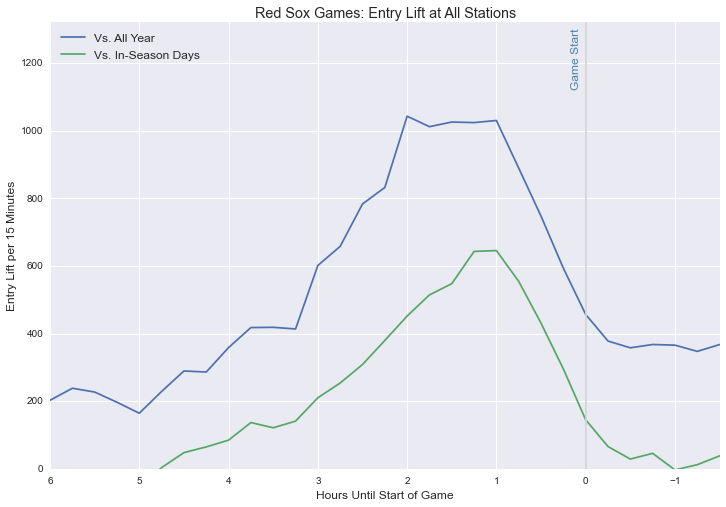

In [329]:
# Plot aggregate.

# Group by hours until start and aggregate. Take care not to use ratios produced by this aggregation.
mean_entry_differences_dow_agg = mean_entry_differences_dow.groupby('hours_until_game_start').agg(np.sum).reset_index()

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_dow_agg.hours_until_game_start, mean_entry_differences_dow_agg.entries_vs_mean_all, label='Vs. All Year')
plt.plot(mean_entry_differences_dow_agg.hours_until_game_start, mean_entry_differences_dow_agg.entries_vs_mean_season, label='Vs. In-Season Days')

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Entry Lift at All Stations', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift per 15 Minutes', fontsize='large')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

#### By Station

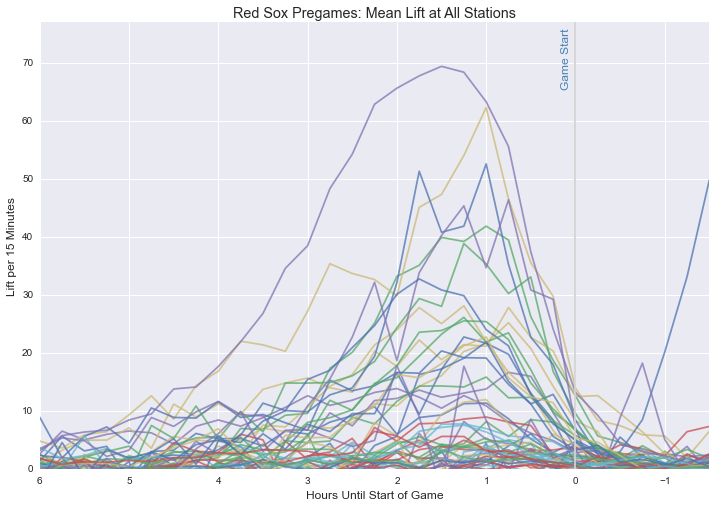

In [330]:
# Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in mean_entry_differences_dow.name.unique():
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    plt.plot(station_entry_differences.hours_until_game_start, station_entry_differences.entries_vs_mean_season, label=station, alpha=0.75)
    # Add note about total over time range.

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Lift per 15 Minutes', fontsize='large')
plt.ylim(ylim)

# Show.
plt.show()

#### Station Sums

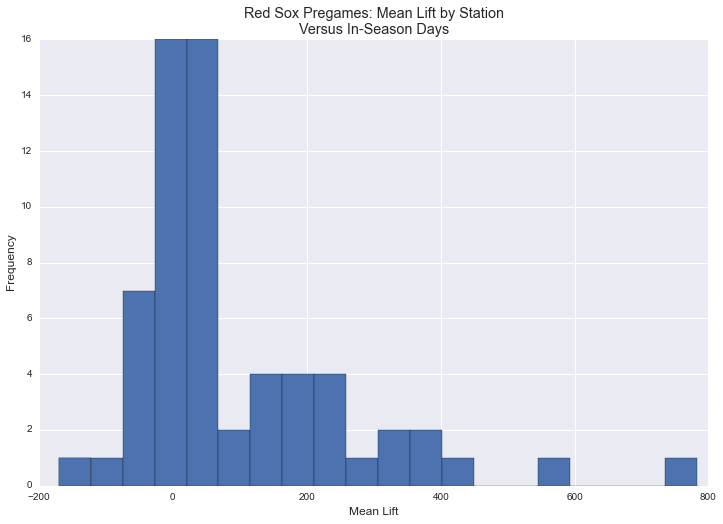

In [331]:
# Calculate sums for each station and plot distribution.

# Calculate sum for each station.
mean_entry_differences_dow_by_station = mean_entry_differences_dow.ix[(mean_entry_differences_dow.hours_until_game_start >= -.5) & (mean_entry_differences_dow.hours_until_game_start <= 4),:].groupby(['name','line_1','line_2']).agg({'entries_vs_mean_season': np.sum, 'entries_vs_mean_all': np.sum, 'mean_entries_all': np.sum, 'mean_entries_season': np.sum})

# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean_season, bins=20)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Station\nVersus In-Season Days', fontsize='x-large')
plt.xlabel('Mean Lift', fontsize='large'); plt.ylabel('Frequency', fontsize='large')

# Show.
plt.show()

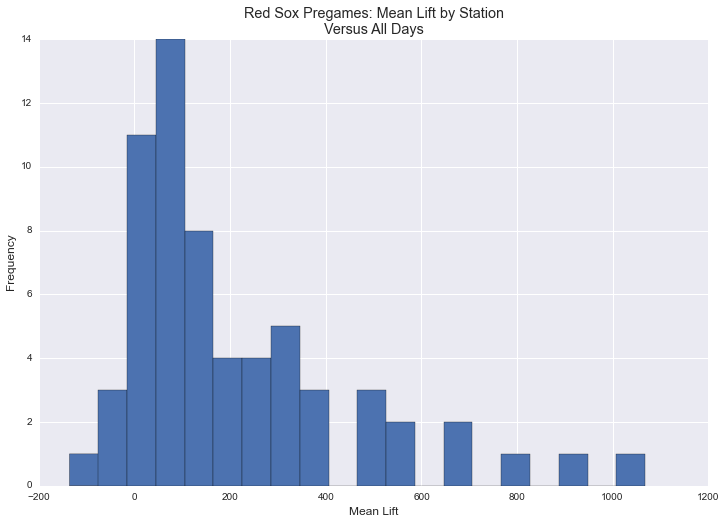

In [332]:
# Version for all days.

# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean_all, bins=20)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Station\nVersus All Days', fontsize='x-large')
plt.xlabel('Mean Lift', fontsize='large'); plt.ylabel('Frequency', fontsize='large')

# Show.
plt.show()

Version for slides:

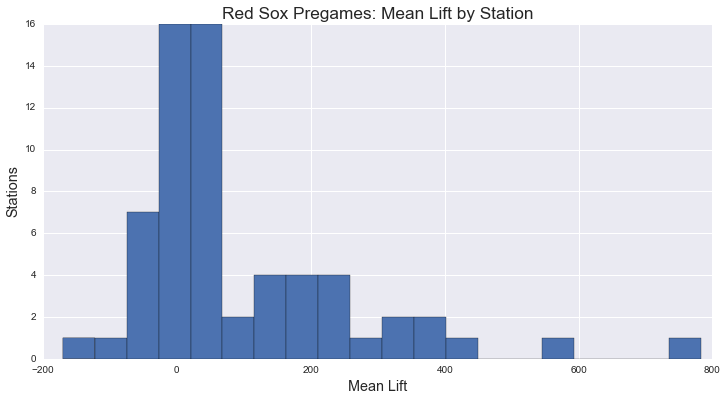

In [334]:
# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean_season, bins=20)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Station', fontsize='xx-large')
plt.xlabel('Mean Lift', fontsize='x-large'); plt.ylabel('Stations', fontsize='x-large')

# Show.
plt.show()

In [534]:
# Calculate slide table for major stations.
major_stations = mean_entry_differences_dow_by_station.sort('entries_vs_mean_season', ascending=False).copy()
major_stations['entries_vs_mean_season_ratio'] = 100*major_stations.entries_vs_mean_season / major_stations.mean_entries_season 
major_stations.drop(['entries_vs_mean_all','mean_entries_all'], axis=1, inplace=True)

In [537]:
# Show particular high-volume stations.
major_stations.head(n=20)

,,,entries_vs_mean_season,mean_entries_season,entries_vs_mean_season_ratio
name,line_1,line_2,,,
Riverside,Green,None,783.364618,564.641442,138.736650
Government Center,Green,Blue,589.616453,4134.953314,14.259326
Park Street,Green,Red,408.219665,7468.556092,5.465845
Alewife,Red,None,393.538333,2360.242851,16.673637
North Station,Orange,Green,390.143024,4027.729703,9.686425
Haymarket,Orange,Green,351.607593,3767.416650,9.332857
Copley Square,Green,None,318.980549,4874.296962,6.544134
Quincy Adams,Red,None,304.560833,750.190683,40.597789
Braintree,Red,None,251.664400,804.790145,31.270810


#### By Line

In [97]:
# Plot lines at individual times.
# Because lines are split by container, we need to be creative.
line_entries = pd.DataFrame(columns=['line','hours_until_game_start','entries_vs_mean_per_line_all','entries_vs_mean_per_line_season'])

# Traverse all lines. line_1 has all unique lines.
for line in mean_entry_differences_dow.line_1.unique():
    # Get traffic for that line, group
    line_condition = ((mean_entry_differences_dow.line_1 == line) | (mean_entry_differences_dow.line_2 == line))
    line_traffic = mean_entry_differences_dow.ix[line_condition,:]
    line_traffic = line_traffic.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line_all':np.sum, 'entries_vs_mean_per_line_season':np.sum}).reset_index()
    line_traffic['line'] = line
    line_traffic = line_traffic[[3,0,1,2]]
    # Append.
    line_entries = line_entries.append(line_traffic)

# Cleanup.
line_entries.reset_index(inplace=True, drop=True)

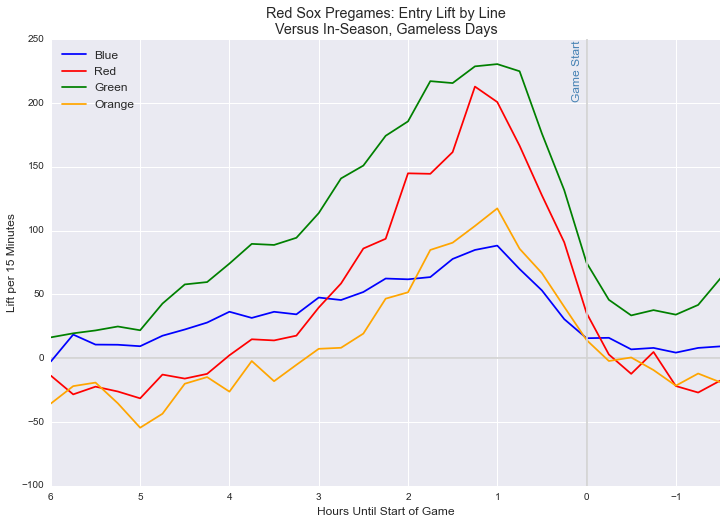

In [112]:
# Start plot.
plt.figure(figsize=default_figsize)
for line in line_entries.line.unique():
    if line != 'Silver':
        plt.plot(line_entries.ix[line_entries.line == line,'hours_until_game_start'], line_entries.ix[line_entries.line == line,'entries_vs_mean_per_line_season'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Entry Lift by Line\nVersus In-Season, Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Lift per 15 Minutes', fontsize='large')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

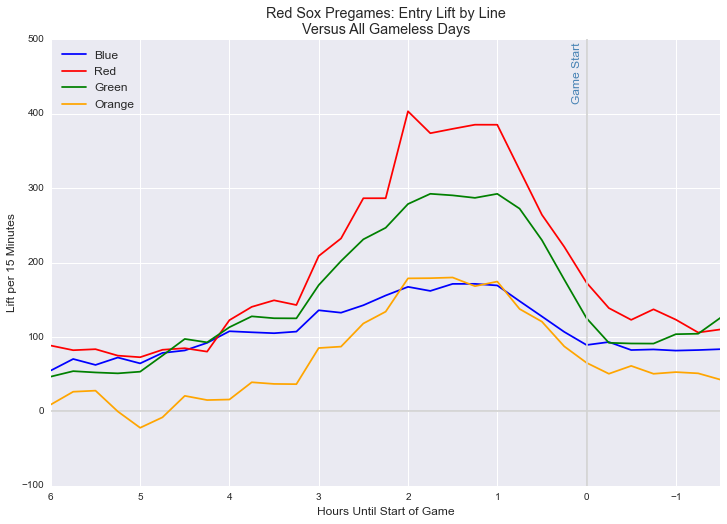

In [107]:
# Start plot.
plt.figure(figsize=default_figsize)
for line in line_entries.line.unique():
    if line != 'Silver':
        plt.plot(line_entries.ix[line_entries.line == line,'hours_until_game_start'], line_entries.ix[line_entries.line == line,'entries_vs_mean_per_line_all'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Entry Lift by Line\nVersus All Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Lift per 15 Minutes', fontsize='large')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

The following tables show aggregate pre-game entry lift for the whole six hours before the game until 30 minutes into it. Though it may be most useful to choose time ranges by line.

In [174]:
# Sum by line.
(
    line_entries[
        (line_entries.hours_until_game_start >= -.5) & (line_entries.line != 'Silver')
    ]
    .groupby('line')
    .agg({'entries_vs_mean_per_line_season':np.sum, 'entries_vs_mean_per_line_all': np.sum})
    .sort('entries_vs_mean_per_line_season', ascending=False)
    .head(n=10)
)

,entries_vs_mean_per_line_all,entries_vs_mean_per_line_season
line,,
Green,4293.828775,2958.172621
Red,5392.750810,1440.923295
Blue,3060.140556,1030.882950
Orange,2026.368420,439.931597


In [175]:
# Aggregate.
agg_line_entries = line_entries[(line_entries.hours_until_game_start >= -.5) & (line_entries.line != 'Silver')].sum()
agg_line_entries.drop(['line','hours_until_game_start'], axis=0, inplace=True)
# Show.
agg_line_entries

entries_vs_mean_per_line_all       14773.09
entries_vs_mean_per_line_season     5869.91
dtype: object

#### Aggregate Scatterplots by Station

Scatterplot by station:

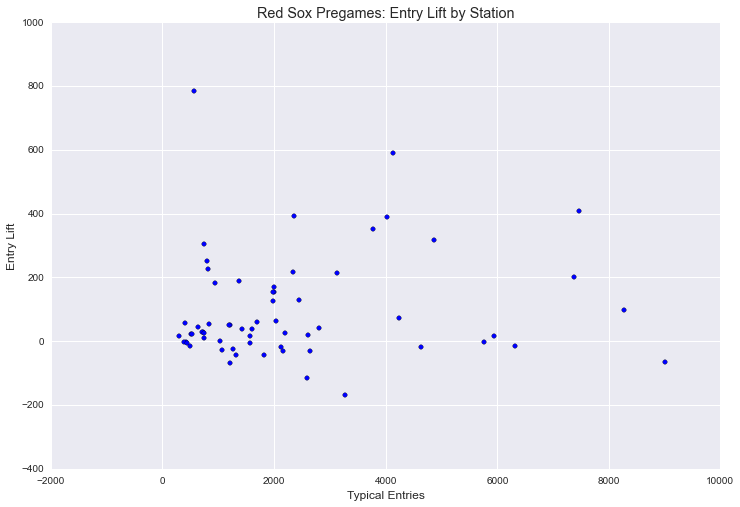

In [484]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.scatter(mean_entry_differences_dow_by_station.mean_entries_season, mean_entry_differences_dow_by_station.entries_vs_mean_season)
# Prettify.
plt.title('Red Sox Pregames: Entry Lift by Station', fontsize='x-large')
plt.xlabel('Typical Entries', fontsize='large')
plt.ylabel('Entry Lift', fontsize='large')
# Show.
plt.show()

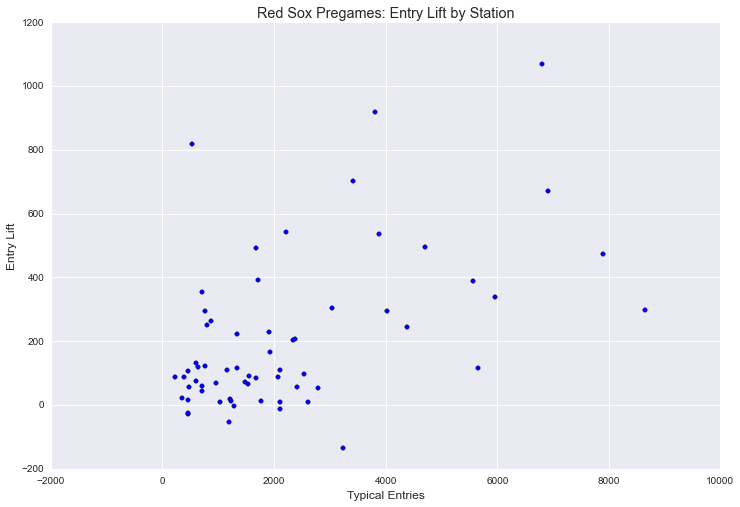

In [485]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.scatter(mean_entry_differences_dow_by_station.mean_entries_all, mean_entry_differences_dow_by_station.entries_vs_mean_all)
# Prettify.
plt.title('Red Sox Pregames: Entry Lift by Station', fontsize='x-large')
plt.xlabel('Typical Entries', fontsize='large')
plt.ylabel('Entry Lift', fontsize='large')
# Show.
plt.show()

### Farebox

Repeat the above for Farebox data.

In [140]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
farebox_sox_gameless = farebox_sox[farebox_sox.game_played == False]

# Aggregate.
gameless_entries_fb_dow = farebox_sox_gameless.groupby(['inbound','publicroute','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_fb_dow.rename(columns={'entries':'mean_entries_all', 'entries_per_line': 'mean_entries_per_line_dir_all'}, inplace=True)

# Also get statistics specific to gameless days during the season.
record_months = pd.DatetimeIndex(farebox_sox_gameless.service_day).month
gameless_entries_fb_dow_season = farebox_sox_gameless.ix[(record_months >= season_start_month) & (record_months <= season_end_month),:]

# Aggregate those as well.
gameless_entries_fb_dow_season = gameless_entries_fb_dow_season.groupby(['inbound','publicroute','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_fb_dow_season.rename(columns={'entries':'mean_entries_season', 'entries_per_line': 'mean_entries_per_line_dir_season'}, inplace=True)

# Merge both into gameless_entries_fb_dow.
gameless_entries_fb_dow = gameless_entries_fb_dow.merge(gameless_entries_fb_dow_season, on=['inbound','publicroute','day_of_week','service_time'], how='left')

In [144]:
# Only consider entries before the game or slightly into it (to determine when entries dissipate.
gametime_condition = ((farebox_sox.time_until_game_start <= np.timedelta64(6,'h')) & (farebox_sox.time_until_game_start >= np.timedelta64(-90,'m')))
game_entries_fb_dow = farebox_sox[farebox_sox.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_fb_dow = game_entries_fb_dow.merge(gameless_entries_fb_dow, on=['inbound','publicroute','day_of_week','service_time'])[['inbound','publicroute','entries','time_until_game_start','mean_entries_all','mean_entries_season']]
entry_differences_fb_dow['entries_vs_mean_all'] = entry_differences_fb_dow.entries - entry_differences_fb_dow.mean_entries_all
entry_differences_fb_dow['entries_vs_mean_season'] = entry_differences_fb_dow.entries - entry_differences_fb_dow.mean_entries_season

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_fb_dow = entry_differences_fb_dow.groupby(['inbound','publicroute','time_until_game_start']).agg({
        'entries_vs_mean_all': np.mean,
        'entries_vs_mean_season': np.mean
    }).reset_index()
mean_entry_differences_fb_dow.time_until_game_start = pd.to_timedelta(mean_entry_differences_fb_dow.time_until_game_start)
mean_entry_differences_fb_dow['hours_until_game_start'] = mean_entry_differences_fb_dow.time_until_game_start.astype(np.int) / timedelta_base

In [147]:
# Extract useful information.
mean_entry_differences_fb_dow_truncated = mean_entry_differences_fb_dow[[0,1,5,3,4]].copy()
# mean_entry_differences_fb_dow_truncated.columns = mean_entry_differences_fb_dow_truncated.columns.get_level_values(0)

In [148]:
mean_entry_differences_fb_dow_truncated.head()

,inbound,publicroute,hours_until_game_start,entries_vs_mean_all,entries_vs_mean_season
0,False,Green Line B,-1.50,-1.262314,-2.749258
1,False,Green Line B,-1.25,-0.406423,-2.382524
2,False,Green Line B,-1.00,-1.093393,-4.044646
3,False,Green Line B,-0.75,-1.145384,-3.146579
4,False,Green Line B,-0.50,2.208678,-0.200166


#### Time Trends

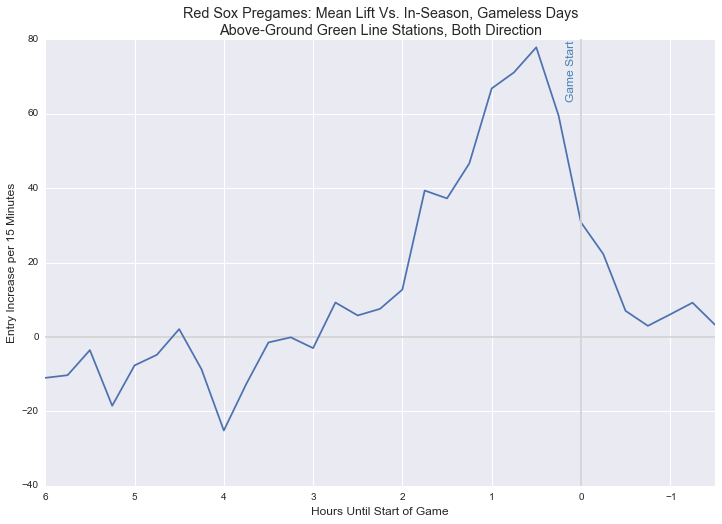

In [159]:
# Plot aggregate.

# Group by hours until start and aggregate.
mean_entry_differences_fb_dow_agg = mean_entry_differences_fb_dow_truncated.groupby('hours_until_game_start').agg(np.sum).reset_index()

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_fb_dow_agg.hours_until_game_start, mean_entry_differences_fb_dow_agg.entries_vs_mean_season)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift Vs. In-Season, Gameless Days\nAbove-Ground Green Line Stations, Both Direction', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='large')

# Show.
plt.show()

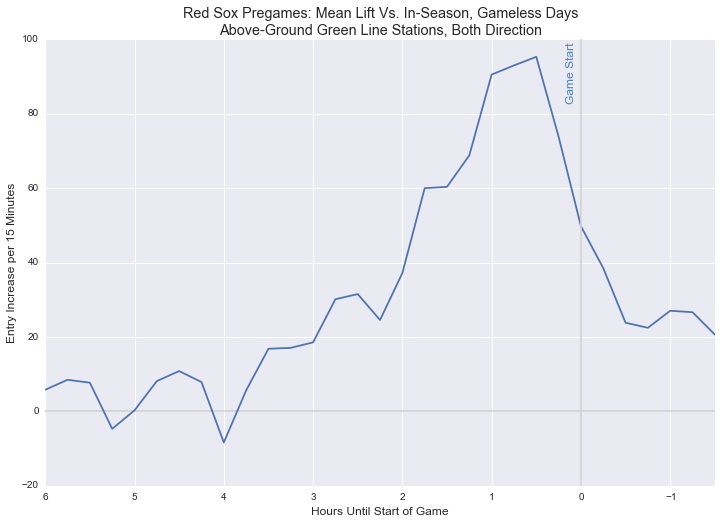

In [160]:
# Same, for all days.

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_fb_dow_agg.hours_until_game_start, mean_entry_differences_fb_dow_agg.entries_vs_mean_all)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift Vs. In-Season, Gameless Days\nAbove-Ground Green Line Stations, Both Direction', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='large')

# Show.
plt.show()

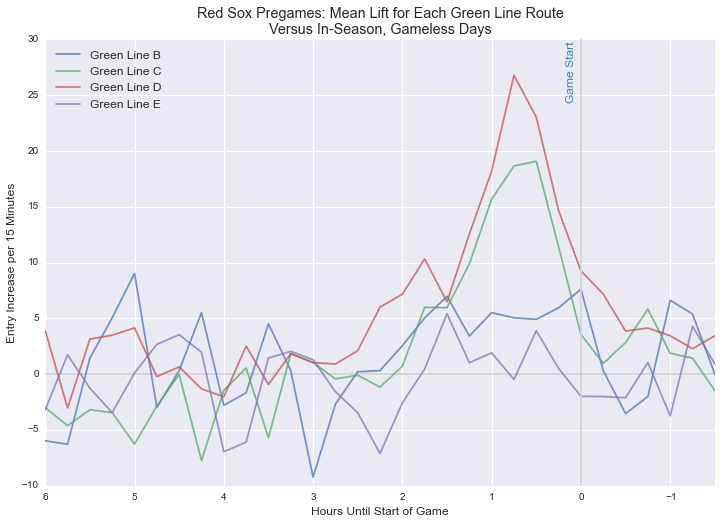

In [176]:
# Plot one line per inbound/outbound, public route.

# Get palette.
pal = sns.color_palette()

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for publicroute in mean_entry_differences_fb_dow.publicroute.unique():
    for inbound in [True]:
        # Get entries.
        route_entry_differences = mean_entry_differences_fb_dow[(mean_entry_differences_fb_dow.publicroute == publicroute) & (mean_entry_differences_fb_dow.inbound == inbound)]
        plt.plot(
            route_entry_differences.hours_until_game_start,
            route_entry_differences.entries_vs_mean_season,
            label=publicroute, #+' '+('Inbound' if inbound else 'Outbound'),
            # c=pal[1 if inbound else 2],
            alpha=0.75
        )

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift for Each Green Line Route\nVersus In-Season, Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='large')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

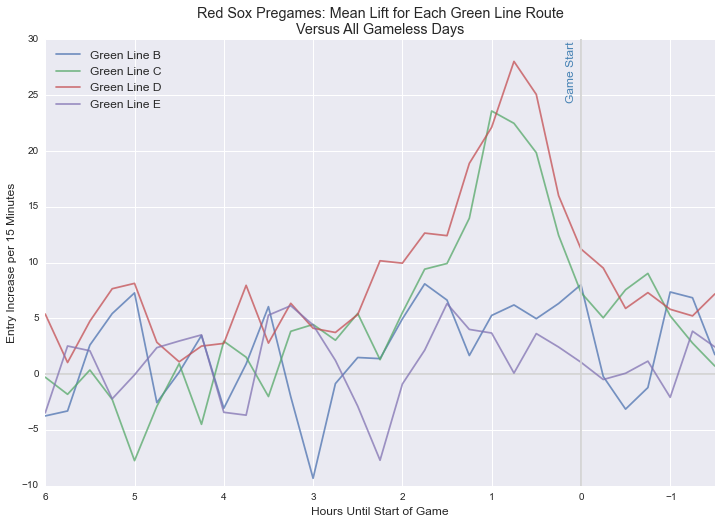

In [177]:
# Same as above, but all days.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for publicroute in mean_entry_differences_fb_dow.publicroute.unique():
    for inbound in [True]:
        # Get entries.
        route_entry_differences = mean_entry_differences_fb_dow[(mean_entry_differences_fb_dow.publicroute == publicroute) & (mean_entry_differences_fb_dow.inbound == inbound)]
        plt.plot(
            route_entry_differences.hours_until_game_start,
            route_entry_differences.entries_vs_mean_all,
            label=publicroute, #+' '+('Inbound' if inbound else 'Outbound'),
            # c=pal[1 if inbound else 2],
            alpha=0.75
        )

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift for Each Green Line Route\nVersus All Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='large')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

In [173]:
# Aggregate across inbound/outbound.
publicroute_entries = mean_entry_differences_fb_dow_truncated.drop('inbound',axis=1).groupby(['publicroute','hours_until_game_start']).agg(np.sum).reset_index(drop=False)
# Add sum by line.
publicroute_entries[(publicroute_entries.hours_until_game_start >= -.5) & (publicroute_entries.hours_until_game_start <= 3)].groupby('publicroute').agg({'entries_vs_mean_season':np.sum, 'entries_vs_mean_all':np.sum}).sort('entries_vs_mean_season', ascending=False).head(n=10)

,entries_vs_mean_all,entries_vs_mean_season
publicroute,,
Green Line D,361.461896,239.607254
Green Line C,283.031459,153.215884
Green Line B,126.340344,91.495593
Green Line E,25.219530,6.849607


### Aggregate

Aggregate Gatecount and Farebox data; include Farebox data in Green Line.

In [222]:
# Reduce farebox entries to Green Line.
fb_entries_reduced = publicroute_entries.groupby('hours_until_game_start').agg({'entries_vs_mean_all': np.sum,'entries_vs_mean_season': np.sum}).reset_index(drop=False)
fb_entries_reduced['line'] = 'Green'
fb_entries_reduced.rename(columns={'entries_vs_mean_all':'entries_vs_mean_per_line_all','entries_vs_mean_season':'entries_vs_mean_per_line_season'}, inplace=True)
# Outer join to line entries for easy sum.
fb_gc_combined = line_entries.append(fb_entries_reduced)
fb_gc_agg = fb_gc_combined.groupby(['line','hours_until_game_start']).agg(np.sum).reset_index(drop=False)
# Group by hours until start and aggregate.
fb_gc_general = fb_gc_agg.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line_all': np.sum,'entries_vs_mean_per_line_season': np.sum}).reset_index(drop=False)

Aggregate trend:

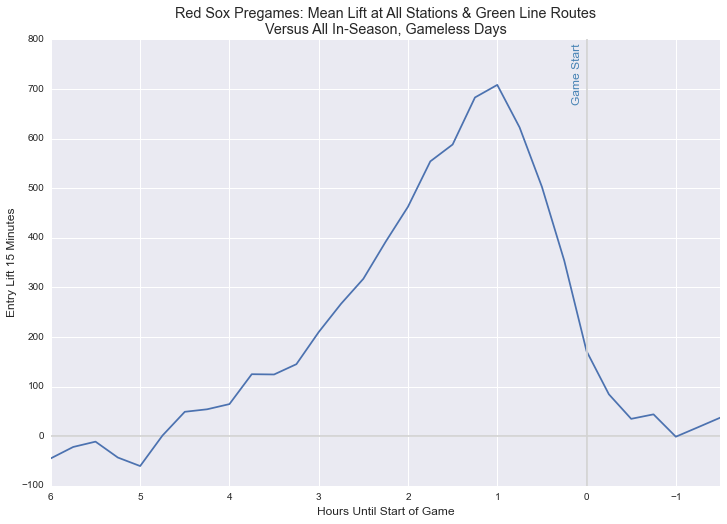

In [325]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(fb_gc_general.hours_until_game_start, fb_gc_general.entries_vs_mean_per_line_season)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim=plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations & Green Line Routes\nVersus All In-Season, Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift 15 Minutes', fontsize='large')
plt.ylim(ylim)

# Show.
plt.show()

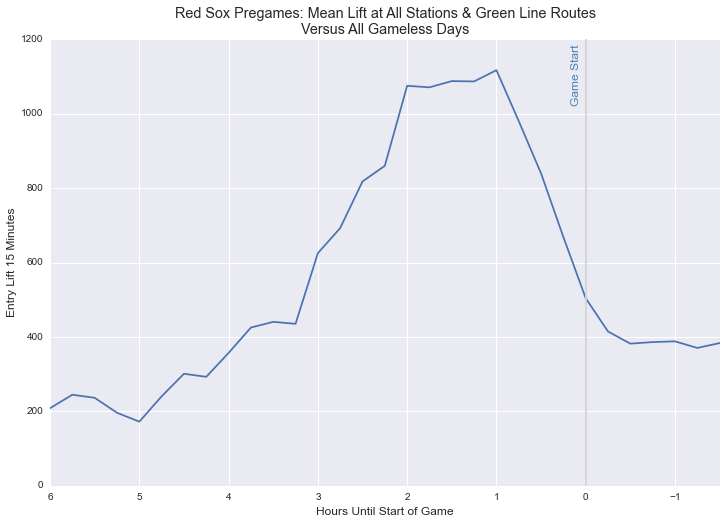

In [201]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(fb_gc_general.hours_until_game_start, fb_gc_general.entries_vs_mean_per_line_all)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim=plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations & Green Line Routes\nVersus All Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift 15 Minutes', fontsize='large')
plt.ylim(ylim)

# Show.
plt.show()

Version for slides:

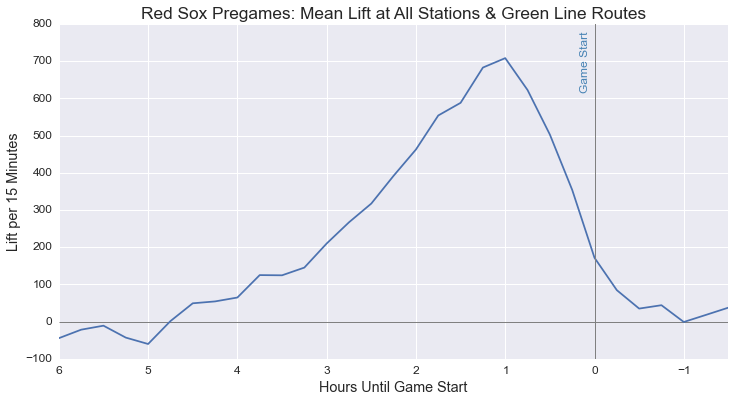

In [524]:
# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.plot(fb_gc_general.hours_until_game_start, fb_gc_general.entries_vs_mean_per_line_season)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim=plt.ylim()
plt.axvline(0, *ylim, color='gray', linewidth=1)
plt.hlines(0, *xlim, colors='gray', linewidth=1)
plt.annotate('Game Start', (.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations & Green Line Routes', fontsize='xx-large')
plt.xlabel('Hours Until Game Start', fontsize='x-large'); plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')
plt.ylim(ylim)

# Show.
plt.show()

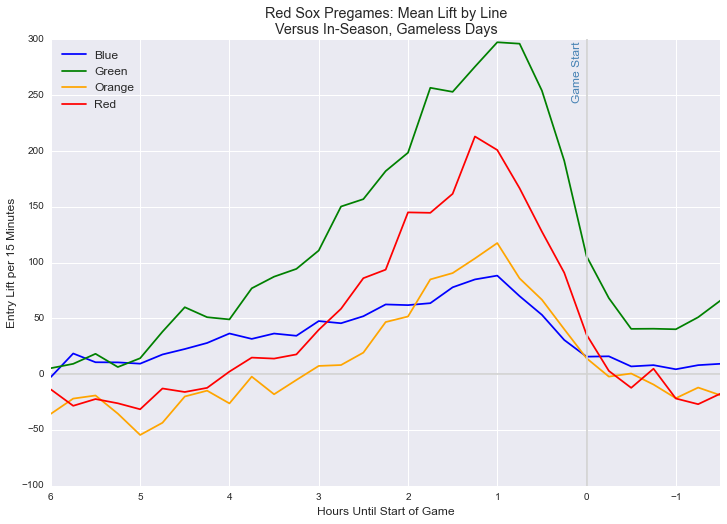

In [207]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize)
for line in fb_gc_agg.line.unique():
    if line != 'Silver':
        plt.plot(fb_gc_agg.ix[fb_gc_agg.line == line,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == line,'entries_vs_mean_per_line_season'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Line\nVersus In-Season, Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift per 15 Minutes', fontsize='large')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

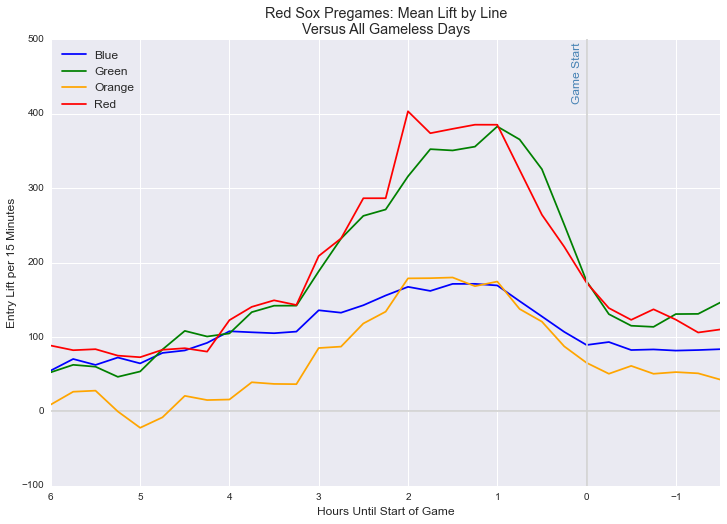

In [216]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize)
for line in fb_gc_agg.line.unique():
    if line != 'Silver':
        plt.plot(fb_gc_agg.ix[fb_gc_agg.line == line,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == line,'entries_vs_mean_per_line_all'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Line\nVersus All Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift per 15 Minutes', fontsize='large')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

Version for slides:

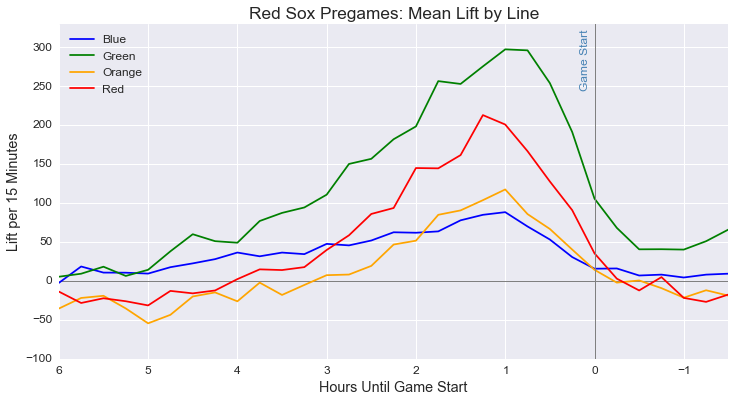

In [523]:
# Start plot.
plt.figure(figsize=default_figsize_slides)
for line in fb_gc_agg.line.unique():
    if line != 'Silver':
        plt.plot(fb_gc_agg.ix[fb_gc_agg.line == line,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == line,'entries_vs_mean_per_line_season'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='gray', linewidth=1)
plt.hlines(0, *xlim, colors='gray', linewidth=1)
plt.annotate('Game Start', (.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Line', fontsize='xx-large')
plt.xlabel('Hours Until Game Start', fontsize='x-large'); plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
plt.legend(loc=2, fontsize='large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')

# Show.
plt.show()

In [493]:
# Add sum by line.
fb_gc_agg_sum_by_line = fb_gc_agg[(fb_gc_agg.hours_until_game_start >= -.5) & (fb_gc_agg.hours_until_game_start <= 4.75) & (fb_gc_agg.line != 'Silver')].groupby('line').agg({'entries_vs_mean_per_line_season':np.sum,'entries_vs_mean_per_line_all':np.sum}).sort('entries_vs_mean_per_line_season', ascending=False).reset_index()
fb_gc_agg_sum_by_line

,line,entries_vs_mean_per_line_all,entries_vs_mean_per_line_season
0,Green,4890.220757,3294.005396
1,Red,4990.668659,1562.657290
2,Blue,2735.326714,984.113585
3,Orange,1984.928423,606.138374


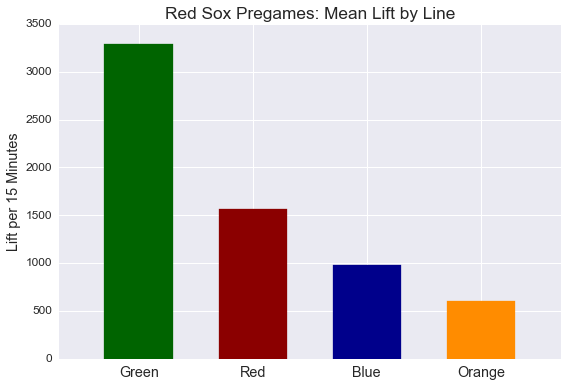

In [516]:
# Bar plot.
plt.figure(figsize=(default_figsize_slides[0]*.75,default_figsize_slides[1]))

# Bar settings.
bar_width = .6

# Plot.
bars = plt.bar(range(len(fb_gc_agg_sum_by_line)), fb_gc_agg_sum_by_line.entries_vs_mean_per_line_season, width=bar_width)

# Color bars.
for bar,line in zip(bars,fb_gc_agg_sum_by_line.line):
    bar.set_color('dark'+line)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift by Line', fontsize='xx-large')
plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
plt.xlim(-(1-bar_width),plt.xlim()[1])
plt.xticks(np.arange(len(fb_gc_agg_sum_by_line))+bar_width/2,fb_gc_agg_sum_by_line.line,fontsize='x-large')
plt.yticks(fontsize='large')

# Show.
plt.show()

In [416]:
# General sum.
# Aggregate
agg_line_gl_entries = fb_gc_agg[(fb_gc_agg.hours_until_game_start >= -.5) & (fb_gc_agg.hours_until_game_start <= 4.75) & (fb_gc_agg.line != 'Silver')].sum()
agg_line_gl_entries.drop(['line','hours_until_game_start'], axis=0, inplace=True)
# Show.
agg_line_gl_entries

entries_vs_mean_per_line_all       14601.14
entries_vs_mean_per_line_season    6446.915
dtype: object

In total, that's about **6,400** entries in the four five hours preceding the game.

## Ranges

### Aggregate

Examine time ranges for ridership in the aggregate.

This is proving difficult. I may revisit this, but until then it works to just use the source data for the simple line chart above.

In [316]:
# Get by-game entries.
game_entry_differences = game_entries_dow.merge(gameless_entries_dow, on=['name','line_1','line_2','day_of_week','service_time'])

# Derive metrics. Negate hours_until_game_start for now to make summary metrics clean.
game_entry_differences['hours_until_game_start'] = - game_entry_differences.time_until_game_start.astype(np.int) / timedelta_base
game_entry_differences['entries_vs_mean_season'] = game_entry_differences.entries - game_entry_differences.mean_entries_season

# Remove late data that we don't want for these ranges.
game_entry_differences = game_entry_differences[(game_entry_differences.hours_until_game_start <= .5) & (game_entry_differences.hours_until_game_start >= -4.75)]

# Whittle our column list.
game_entry_differences = game_entry_differences[['name','game_date','hours_until_game_start','entries_vs_mean_season']]

# Aggregate by game, hours.
game_entries_aggregate = game_entry_differences.groupby(['game_date','hours_until_game_start']).agg(np.sum).reset_index()

# Aggregate by hours. Will be used for running proportions.
game_entries_by_game = game_entries_aggregate.groupby('game_date').agg({'entries_vs_mean_season':np.sum}).reset_index()
game_entries_by_game.rename(columns={'entries_vs_mean_season':'game_entries'}, inplace=True)

# Now get cumulative sums.
game_entries_aggregate_cumulative = game_entries_aggregate.groupby(['game_date','hours_until_game_start']).sum().groupby(level=[0]).cumsum().reset_index()

# Join the above and calculate proportional running sum.
game_entries_aggregate_cumulative = game_entries_aggregate_cumulative.merge(game_entries_by_game, on='game_date')
game_entries_aggregate_cumulative['entries_cum_proportion'] = game_entries_aggregate_cumulative.entries_vs_mean_season / game_entries_aggregate_cumulative.game_entries

# Clean up hours_until_game_start.
game_entries_aggregate_cumulative.hours_until_game_start = -game_entries_aggregate_cumulative.hours_until_game_start

In [317]:
game_entries_aggregate_cumulative.head()

,game_date,hours_until_game_start,entries_vs_mean_season,game_entries,entries_cum_proportion
0,2013-04-08,4.75,773.611023,13224.011946,0.058500
1,2013-04-08,4.50,1310.178393,13224.011946,0.099076
2,2013-04-08,4.25,1832.617172,13224.011946,0.138583
3,2013-04-08,4.00,2332.980918,13224.011946,0.176420
4,2013-04-08,3.75,2865.275736,13224.011946,0.216672


Here, I'll reuse data from above.

In [357]:
# Get data in primary time range.
primary_range_agg = fb_gc_general[(fb_gc_general.hours_until_game_start >= -1) & (fb_gc_general.hours_until_game_start <= 4.75)].copy()
primary_range_agg.drop('entries_vs_mean_per_line_all', axis=1, inplace=True)
primary_range_agg.rename(columns={'entries_vs_mean_per_line_season':'entries'}, inplace=True)
primary_range_agg.sort('hours_until_game_start', ascending=True, inplace=True)

# Get cumulative sum.
primary_range_agg['cum_entries'] = primary_range_agg.entries.cumsum()
# Get proportional sum.
primary_range_agg['cum_entries_proportional'] = primary_range_agg.cum_entries / primary_range_agg.entries.sum()

In [387]:
# Key time range percentiles.
percentiles = [.125, .25, .75, .875]
percentile_hours_until_game_start = {}

# Calculate for each percentile.
for p in percentiles:
    rec_below = primary_range_agg[primary_range_agg.cum_entries_proportional < p].iloc[-1,:]
    rec_above = primary_range_agg[primary_range_agg.cum_entries_proportional >= p].iloc[0,:]
    percentile_hours_until_game_start[p] = rec_below.hours_until_game_start +.25*(p-rec_below.cum_entries_proportional) / (rec_above.cum_entries_proportional-rec_below.cum_entries_proportional)

Plot!

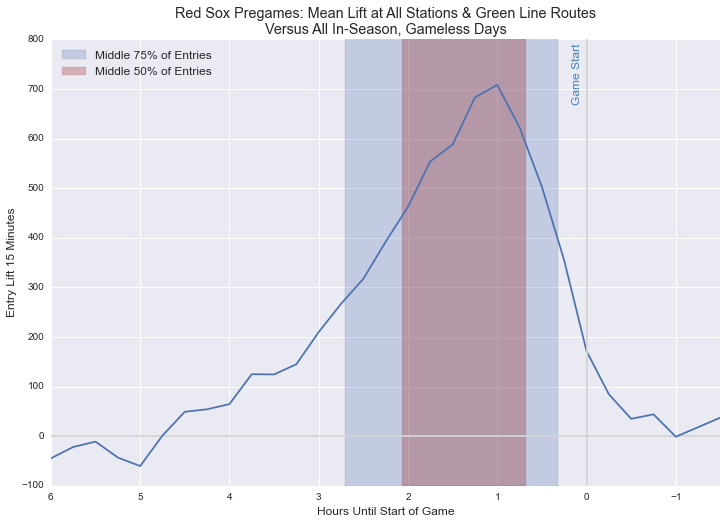

In [409]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(fb_gc_general.hours_until_game_start, fb_gc_general.entries_vs_mean_per_line_season)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim=plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='large')
# Reverse axis.
plt.gca().invert_xaxis()

# Spans.
plt.axvspan(
    xmin=percentile_hours_until_game_start[.125], xmax=percentile_hours_until_game_start[.875],
    ymin=0, ymax=1,
    alpha=0.25, label='Middle 75% of Entries'
)
plt.axvspan(
    xmin=percentile_hours_until_game_start[.25], xmax=percentile_hours_until_game_start[.75],
    ymin=0, ymax=1,
    color='darkred', alpha=0.25, label='Middle 50% of Entries'
)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations & Green Line Routes\nVersus All In-Season, Gameless Days', fontsize='x-large')
plt.xlabel('Hours Until Start of Game', fontsize='large'); plt.ylabel('Entry Lift 15 Minutes', fontsize='large')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

Version for slides:

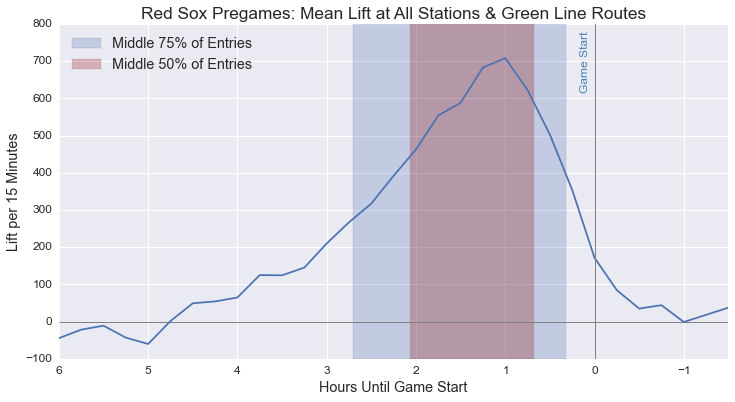

In [522]:
# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.plot(fb_gc_general.hours_until_game_start, fb_gc_general.entries_vs_mean_per_line_season)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim=plt.ylim()
plt.axvline(0, *ylim, color='gray', linewidth=1)
plt.hlines(0, *xlim, colors='gray', linewidth=1)
plt.annotate('Game Start', (.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')
# Reverse axis.
plt.gca().invert_xaxis()

# Spans.
plt.axvspan(
    xmin=percentile_hours_until_game_start[.125], xmax=percentile_hours_until_game_start[.875],
    ymin=0, ymax=1,
    alpha=0.25, label='Middle 75% of Entries'
)
plt.axvspan(
    xmin=percentile_hours_until_game_start[.25], xmax=percentile_hours_until_game_start[.75],
    ymin=0, ymax=1,
    color='darkred', alpha=0.25, label='Middle 50% of Entries'
)

# Prettify.
plt.title('Red Sox Pregames: Mean Lift at All Stations & Green Line Routes', fontsize='xx-large')
plt.xlabel('Hours Until Game Start', fontsize='x-large'); plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='x-large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')

# Show.
plt.show()

### By Line

In [437]:
# Gameday lift starts differently for different lines.
lines = ['Blue','Green','Orange','Red']
range_starts_by_line = {
    'Blue': 6,
    'Green': 6,
    'Orange': 3.25,
    'Red': 4
}
# Container for percentile stats.
line_percentiles = dict([(l,{}) for l in lines])

In [438]:
# Calculate for each line.
for l in lines:
    # Get line data.
    line_range_agg = fb_gc_agg.ix[fb_gc_agg.line == l,:]
    
    # Get data in primary time range.
    line_range_agg = line_range_agg[(line_range_agg.hours_until_game_start >= -1) & (line_range_agg.hours_until_game_start <= range_starts_by_line[l])].copy()
    line_range_agg.drop('entries_vs_mean_per_line_all', axis=1, inplace=True)
    line_range_agg.rename(columns={'entries_vs_mean_per_line_season':'entries'}, inplace=True)
    line_range_agg.sort('hours_until_game_start', ascending=True, inplace=True)
    # Get cumulative sum.
    line_range_agg['cum_entries'] = line_range_agg.entries.cumsum()
    # Get proportional sum.
    line_range_agg['cum_entries_proportional'] = line_range_agg.cum_entries / line_range_agg.entries.sum()
    
    # Calculate for each percentile.
    for p in percentiles:
        rec_below = line_range_agg[line_range_agg.cum_entries_proportional < p].iloc[-1,:]
        rec_above = line_range_agg[line_range_agg.cum_entries_proportional >= p].iloc[0,:]
        line_percentiles[l][p] = rec_below.hours_until_game_start +.25*(p-rec_below.cum_entries_proportional) / (rec_above.cum_entries_proportional-rec_below.cum_entries_proportional)

Now plot using subplots.

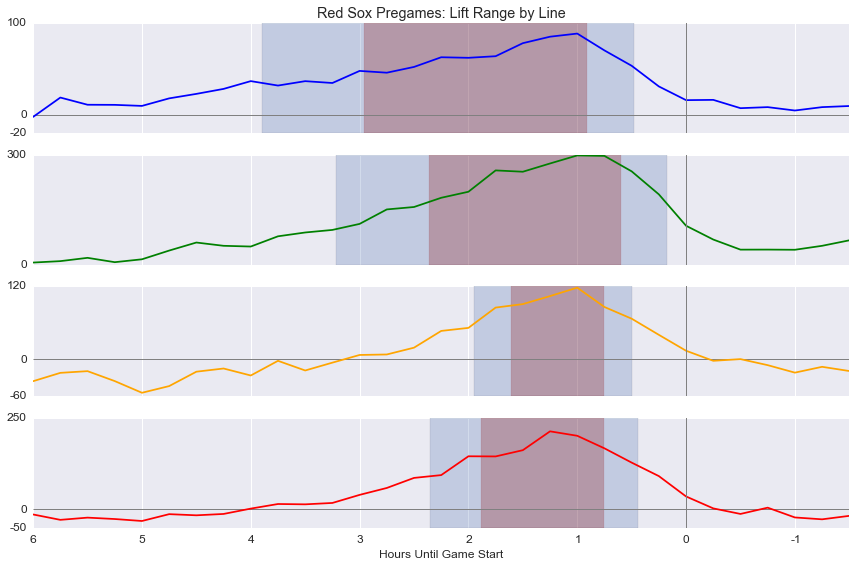

In [550]:
# Start subplots.
f, axes = plt.subplots(4, sharex=True)

# Adjust size.
f.set_figwidth(default_figsize[0])
f.set_figheight(default_figsize[1])

# Plot each.
for l,ax in zip(lines,axes):
    if l == 'Blue':
        ax.set_title('Red Sox Pregames: Lift Range by Line', fontsize='x-large')
    # Plot line.
    ax.plot(fb_gc_agg.ix[fb_gc_agg.line == l,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == l,'entries_vs_mean_per_line_season'], c=l, label=l)
    # Add line at 0.
    if ax.get_ylim()[0] < 0:
        ax.hlines(0, *xlim, colors='gray', linewidth=1)
        # Set ticks.
        ax.set_yticks([ax.get_ylim()[0],0,ax.get_ylim()[1]])
    else:
        # Set ticks.
        ax.set_yticks([ax.get_ylim()[0],ax.get_ylim()[1]])
    # Add line at game start.
    ax.axvline(0, *ax.get_ylim(), color='gray', linewidth=1)
    # Add spans.
    ax.axvspan(
        xmin=line_percentiles[l][.125], xmax=line_percentiles[l][.875],
        ymin=0, ymax=1,
        alpha=0.25, label='Middle 75% of Entries'
    )
    ax.axvspan(
        xmin=line_percentiles[l][.25], xmax=line_percentiles[l][.75],
        ymin=0, ymax=1,
        color='darkred', alpha=0.25, label='Middle 50% of Entries'
    )
    # Prettify ticks.
    ax.set_yticklabels(ax.get_yticks().astype(np.int),fontsize='large')
    ax.set_xticklabels(ax.get_xticks().astype(np.int),fontsize='large')

# Limits.
plt.xlim((-1.5,6))
plt.xlabel('Hours Until Game Start', fontsize='large')

# Reverse axis, tighten layout.
plt.gca().invert_xaxis()
f.tight_layout()

# Show.
f.show()

Slide version!

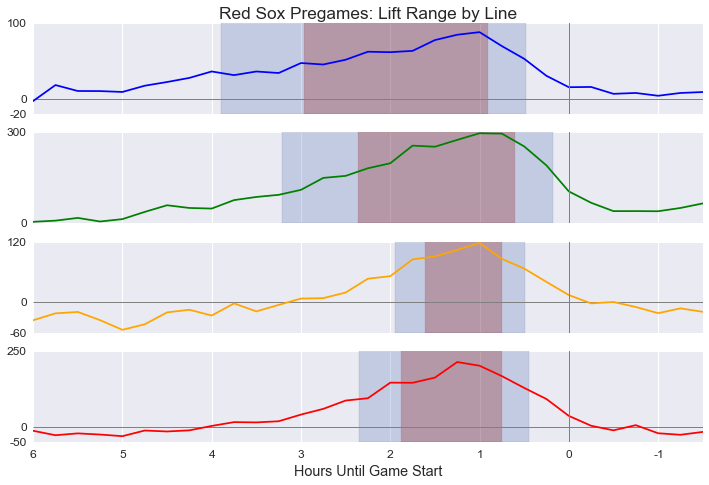

In [551]:
# Start subplots.
f, axes = plt.subplots(4, sharex=True)

# Adjust size.
f.set_figwidth(default_figsize_slides[0])
f.set_figheight(default_figsize_slides[1]*1.25)

# Plot each.
for l,ax in zip(lines,axes):
    if l == 'Blue':
        ax.set_title('Red Sox Pregames: Lift Range by Line', fontsize='xx-large')
    # Plot line.
    ax.plot(fb_gc_agg.ix[fb_gc_agg.line == l,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == l,'entries_vs_mean_per_line_season'], c=l, label=l)
    # Add line at 0.
    if ax.get_ylim()[0] < 0:
        ax.hlines(0, *xlim, colors='gray', linewidth=1)
        # Set ticks.
        ax.set_yticks([ax.get_ylim()[0],0,ax.get_ylim()[1]])
    else:
        # Set ticks.
        ax.set_yticks([ax.get_ylim()[0],ax.get_ylim()[1]])
    # Add line at game start.
    ax.axvline(0, *ax.get_ylim(), color='gray', linewidth=1)
    # Add spans.
    ax.axvspan(
        xmin=line_percentiles[l][.125], xmax=line_percentiles[l][.875],
        ymin=0, ymax=1,
        alpha=0.25, label='Middle 75% of Entries'
    )
    ax.axvspan(
        xmin=line_percentiles[l][.25], xmax=line_percentiles[l][.75],
        ymin=0, ymax=1,
        color='darkred', alpha=0.25, label='Middle 50% of Entries'
    )
    # Prettify ticks.
    ax.set_yticklabels(ax.get_yticks().astype(np.int),fontsize='large')
    ax.set_xticklabels(ax.get_xticks().astype(np.int),fontsize='large')

# Limits.
plt.xlim((-1.5,6))
plt.xlabel('Hours Until Game Start', fontsize='x-large')

# Prettify.
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')

# Reverse axis, tighten layout.
plt.gca().invert_xaxis()
# f.tight_layout()

# Show.
f.show()